# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,2.234403,True,8.280170
1,0.044477,True,5.258781
2,-0.747671,False,0.812865
3,1.371823,True,7.196454
4,1.098892,False,-1.650252
...,...,...,...
995,0.440217,True,4.662790
996,1.823214,True,6.285280
997,0.892812,True,5.304615
998,1.404442,False,2.402860


<AxesSubplot:xlabel='v0'>

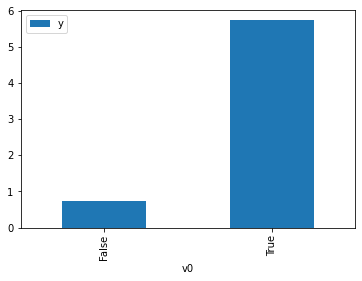

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

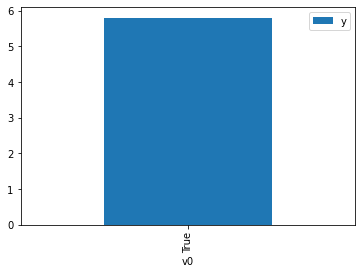

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.732135,False,2.218457,0.316933,3.155236
1,1.496649,False,2.283477,0.179581,5.568530
2,-0.281703,False,0.438987,0.556854,1.795802
3,0.697331,False,2.547611,0.324384,3.082767
4,0.035416,False,0.472348,0.479204,2.086792
...,...,...,...,...,...
995,0.701647,False,1.131739,0.323455,3.091621
996,0.384661,False,-1.221794,0.394978,2.531788
997,0.415265,False,-0.606517,0.387814,2.578555
998,1.496649,False,2.283477,0.179581,5.568530


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.064851,True,4.472908,0.496174,2.015420
1,1.431383,True,5.339728,0.810775,1.233388
2,-0.273112,True,5.193136,0.445230,2.246029
3,1.667211,True,6.461664,0.843803,1.185110
4,1.220988,True,4.873686,0.777005,1.286993
...,...,...,...,...,...
995,2.004996,True,6.696283,0.882751,1.132822
996,0.874846,True,5.908978,0.712620,1.403272
997,0.147848,True,5.895636,0.548279,1.823890
998,-0.054557,True,5.599074,0.498703,2.005200


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                          1.182e+04
Date:                Wed, 20 Jul 2022   Prob (F-statistic):                        0.00
Time:                        18:01:39   Log-Likelihood:                         -1443.9
No. Observations:                1000   AIC:                                      2892.
Df Residuals:                     998   BIC:                                      2902.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8190      0.034     23.884      0.000       0.752       0.886
x2             5.0003      0.056     89.008      0.000       4.890       5.110
==============================================================================
Omnibus:                        2.248   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.325   Jarque-Bera (JB):                2.226
Skew:                          -0.116   Prob(JB):                        0.329
Kurtosis:                       2.994   Cond. No.                         2.87
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""